In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


pd.options.display.float_format = "{:,.2f}".format

In [7]:
df2018 = pd.read_csv('DADOS/MICRODADOS_ENEM_2018.csv',
                     nrows = 1000000, sep = ';', encoding = 'ISO-8859-1')


df2018.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008202043,2018,5300108,Brasília,53,DF,44.00,M,1.00,1,...,A,A,A,A,A,A,A,A,B,A
1,180007197856,2018,2111102,São João dos Patos,21,MA,23.00,F,0.00,3,...,A,B,A,A,B,A,A,A,A,A
2,180008517434,2018,3530607,Mogi das Cruzes,35,SP,23.00,F,0.00,1,...,A,B,A,A,B,B,B,B,A,A
3,180007661228,2018,2916401,Itapetinga,29,BA,26.00,F,0.00,3,...,A,B,B,A,C,A,B,B,A,A
4,180008787987,2018,2918100,Jeremoabo,29,BA,20.00,M,0.00,0,...,A,B,A,A,B,A,B,B,B,A


## Data cleaning

### Removing some irrelevant columns

Some columns can be seen directly as been irrelevant for us, the first of them is
the enrollment number, since we are interested in the social information and this
is an individual number to each applicant. Another one is the NU_ANO, since it
corresponds to the year of the specific national exam. Also 'CO_MUNICIPIO_RESIDENCIA'
is equivalent to 'NO_MUNICIPIO_RESIDENCIA' and 'CO_UF_RESIDENCIA' is equivalent to 'SG_UF_RESIDENCIA'.

In [8]:
cols = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'CO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'TP_NACIONALIDADE', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO']

df2018 = df2018.drop(columns = cols)

df2018.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,Brasília,DF,44.00,M,1.00,1,2,0,2,1.00,...,A,A,A,A,A,A,A,A,B,A
1,São João dos Patos,MA,23.00,F,0.00,3,1,5,1,1.00,...,A,B,A,A,B,A,A,A,A,A
2,Mogi das Cruzes,SP,23.00,F,0.00,1,1,3,1,3.00,...,A,B,A,A,B,B,B,B,A,A
3,Itapetinga,BA,26.00,F,0.00,3,1,8,1,1.00,...,A,B,B,A,C,A,B,B,A,A
4,Jeremoabo,BA,20.00,M,0.00,0,2,0,2,1.00,...,A,B,A,A,B,A,B,B,B,A


For the model prediction, we are also not interested in information regarding the answers
given by the students at the answer card. Nor the test informations, like the test number and so on

In [9]:
cols = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'TX_GABARITO_CN',
        'TX_GABARITO_CH', 'TX_GABARITO_LC','TX_GABARITO_MT','TP_STATUS_REDACAO',
        'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 
        'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

df2018 = df2018.drop(columns = cols)

### Analyzing absent applicants

The columns containing "PRESENCA" in the name, tells us when the applicants were present 
or not in the test. Let's analyze this and also remove those applicants which were absent

In [10]:
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

## Removing those which didn't show up for the test

df2018 = df2018[(df2018.TP_PRESENCA_CN == 1) & (df2018.TP_PRESENCA_CH == 1) & (df2018.TP_PRESENCA_LC == 1) & (df2018.TP_PRESENCA_MT == 1)]

print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 0]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 1]))
print(len(df2018[['TP_PRESENCA_CN']][df2018.TP_PRESENCA_CN == 2]))

246923
752939
117
0
751379
0


### Analyzing the nan-values

In [11]:
df2018.drop(columns = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'], inplace = True)

In [12]:
print(df2018.iloc[:, : 60].isna().sum())
print(df2018.iloc[:, 60: 120].isna().sum())
print(df2018.iloc[:, 120: ].isna().sum())

NO_MUNICIPIO_RESIDENCIA             0
SG_UF_RESIDENCIA                    0
NU_IDADE                            7
TP_SEXO                             0
TP_ESTADO_CIVIL                 23679
TP_COR_RACA                         0
TP_ST_CONCLUSAO                     0
TP_ANO_CONCLUIU                     0
TP_ESCOLA                           0
TP_ENSINO                      200067
IN_TREINEIRO                        0
CO_ESCOLA                      510067
CO_MUNICIPIO_ESC               510067
NO_MUNICIPIO_ESC               510067
CO_UF_ESC                      510067
SG_UF_ESC                      510067
TP_DEPENDENCIA_ADM_ESC         510067
TP_LOCALIZACAO_ESC             510067
TP_SIT_FUNC_ESC                510067
IN_BAIXA_VISAO                      0
IN_CEGUEIRA                         0
IN_SURDEZ                           0
IN_DEFICIENCIA_AUDITIVA             0
IN_SURDO_CEGUEIRA                   0
IN_DEFICIENCIA_FISICA               0
IN_DEFICIENCIA_MENTAL               0
IN_DEFICIT_A

In [13]:
## Let's start by analyzing the following set of columns

df2018[['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
        'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']].head()

,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"23,077,140.00","2,304,400.00",Fortaleza,23.00,CE,2.00,1.00,1.00
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These columns represent most likely the same information (city and state).
However, since most of the high school students study on their own hometown,
for most people these information do not bring any extra information .
Since most of them are nan-values, let's simply drop them out.

In [14]:
df2018.drop(columns = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
                       'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
                       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC'], inplace = True)

In [15]:
print(df2018.iloc[:, : 15].isna().sum())

NO_MUNICIPIO_RESIDENCIA         0
SG_UF_RESIDENCIA                0
NU_IDADE                        7
TP_SEXO                         0
TP_ESTADO_CIVIL             23679
TP_COR_RACA                     0
TP_ST_CONCLUSAO                 0
TP_ANO_CONCLUIU                 0
TP_ESCOLA                       0
TP_ENSINO                  200067
IN_TREINEIRO                    0
IN_BAIXA_VISAO                  0
IN_CEGUEIRA                     0
IN_SURDEZ                       0
IN_DEFICIENCIA_AUDITIVA         0
dtype: int64


The column *TP_ENSINO* corresponds to the kind of school that
the student has came from, *i.e.*, regular schools (1), high school
done in a shorter time (2) and schools for adults (3). We can take a look
on their kind of school and their age to analyse its nan-values and fill
at least some of them with some guessing.

In [16]:
# Okay, there a bunch of people younger than 17-18 (which is
#the age that most people are finishing their high schools), so for
#these people we can fill up with regular school right away

df2018[['NU_IDADE', 'TP_ENSINO']][df2018.TP_ENSINO.isna()].head(10)

,NU_IDADE,TP_ENSINO
22,29.00,NaN
27,19.00,NaN
31,16.00,NaN
59,16.00,NaN
122,15.00,NaN
174,18.00,NaN
193,19.00,NaN
203,41.00,NaN
230,18.00,NaN
239,19.00,NaN


In [17]:
cond = (df2018.TP_ENSINO.isna()) & (df2018.NU_IDADE <= 20)

df2018.loc[cond] = df2018.loc[cond].fillna(1)

df2018.TP_ENSINO.value_counts(dropna = False)

1.00    642392
NaN      67703
3.00     38984
2.00      2300
Name: TP_ENSINO, dtype: int64

The rest of nan-values probably lie within the groups 2 or 3.
However the data is pretty unbalanced and we might join the groups
2 and 3 together later on.

In [18]:
df2018.TP_ENSINO = df2018.TP_ENSINO.fillna(2)

print(df2018.iloc[:, : 10].isna().sum())

NO_MUNICIPIO_RESIDENCIA        0
SG_UF_RESIDENCIA               0
NU_IDADE                       7
TP_SEXO                        0
TP_ESTADO_CIVIL            21218
TP_COR_RACA                    0
TP_ST_CONCLUSAO                0
TP_ANO_CONCLUIU                0
TP_ESCOLA                      0
TP_ENSINO                      0
dtype: int64


### Analyzing the marital status of the applicants

In [19]:
## Again, even filling the nan-values properly, it won't help that much
## due to unbalanced data. Therefore we will split it later on single and non-single people

df2018.TP_ESTADO_CIVIL.value_counts(dropna = False)

0.00    674863
1.00     47706
NaN      21218
2.00      6952
3.00       640
Name: TP_ESTADO_CIVIL, dtype: int64

In [20]:
cond = (df2018.TP_ESTADO_CIVIL.isna()) & (df2018.NU_IDADE <= 25)
cols = ['TP_ESTADO_CIVIL', 'NU_IDADE']

df2018.loc[cond, cols] = df2018.loc[cond, cols].fillna(0)

df2018.TP_ESTADO_CIVIL = df2018.TP_ESTADO_CIVIL.fillna(1)

In [21]:
# Filling the missing data related to age

df2018.NU_IDADE = df2018.NU_IDADE.fillna(round(df2018.NU_IDADE.mean()))

print(df2018.iloc[:, : 6].isna().sum())

NO_MUNICIPIO_RESIDENCIA    0
SG_UF_RESIDENCIA           0
NU_IDADE                   0
TP_SEXO                    0
TP_ESTADO_CIVIL            0
TP_COR_RACA                0
dtype: int64


### Dealing with the students which scored zero in the essay

When someone scores zero in the essay this applicant will not be able to enroll
most of the universties. Therefore, it is safe to drop them out. Let's investigate

In [22]:
print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

## If someone scored 0 at the essay it won't be accept in most
## of the universities. So we will drop this candidate
df2018 = df2018[df2018.NU_NOTA_REDACAO != 0]

print(len(df2018.NU_NOTA_REDACAO[df2018.NU_NOTA_REDACAO == 0]))

12203
0


In [23]:
# Checking those students which were present in the tests



## Some feature engineering

There are some information which are not particularly relevant due to how unbalanced is the data in some features.
One of them is the marital status. Most people applying is single and the rest is divided into three categories.
Might be useful to create:
- Single (1) not single (0) instead of marital status.
- Regarding the city, it might be worth checking whether the applicant lives in the capital or not.

In [24]:
## Creating the capital information

state_capitals = ['Rio Branco', 'Macapá', 'Manaus', 'Belém', 'Porto Velho', 'Boa Vista', 'Palmas', 'Maceió', 'Salvador', 'Fortaleza',
               'São Luís', 'João Pessoa', 'Recife', 'Teresina', 'Natal', 'Aracaju', 'Goiânia', 'Cuiabá', 'Campo Grande', 'Brasília',
               'Vitória', 'Belo Horizonte', 'São Paulo', 'Rio de Janeiro', 'Curitiba', 'Porto Alegre', 'Florianópolis']

df2018['capital_or_not'] = df2018['NO_MUNICIPIO_RESIDENCIA'].isin(state_capitals)
df2018['capital_or_not'] = df2018['capital_or_not'].apply(lambda row : 1 if row == True else 0)

df2018[['NO_MUNICIPIO_RESIDENCIA', 'capital_or_not']]

#df2018 = df2018.drop(columns = ['NO_MUNICIPIO_RESIDENCIA'])

,NO_MUNICIPIO_RESIDENCIA,capital_or_not
1,São João dos Patos,0
5,João Pessoa,1
7,Parnaíba,0
8,Fortaleza,1
9,Cuiabá,1
...,...,...
999994,Ibipeba,0
999995,Londrina,0
999996,Salgueiro,0
999997,Santo Estêvão,0


In [25]:
df2018['single_or_not'] = df2018['TP_ESTADO_CIVIL'].apply(lambda row: 1 if row ==  0 else 0)

df2018[['single_or_not','TP_ESTADO_CIVIL']].head(10)

,single_or_not,TP_ESTADO_CIVIL
1,1,0.00
5,1,0.00
7,0,1.00
8,1,0.00
9,1,0.00
12,1,0.00
13,1,0.00
16,1,0.00
17,1,0.00
18,1,0.00


## Recap the plan

The main idea of this project is to show how relevant social status is in the development of someone.
Unfortunately Brazil doesn't have, in general, good public schools (apart from the federal ones, which
are quite good indeed, but you access them from a test, and again we fall in the same pit, if you have
money you can pay for preparatory courses or just good private schools). So the main idea was to developed
a regressor which can predict grades based on social information. But I am not particularly specifically
on the grades, I could make a classification problem and specify some ranges, for example, if someone is
above or below the average of an specific grade.

In attempt to do so, let's create 5 columns which are going to be our target variable turning it into
a classification problem.

In [26]:
avg_cn = round(df2018.NU_NOTA_CN.mean())
avg_ch = round(df2018.NU_NOTA_CH.mean())
avg_lc = round(df2018.NU_NOTA_LC.mean())
avg_mt = round(df2018.NU_NOTA_MT.mean())
avg_red = round(df2018.NU_NOTA_REDACAO.mean())

## Creating the columns for above or below the mean for each subject

df2018_clf = df2018.copy()
df2018_clf = df2018_clf[df2018_clf.Q026 != 1]
df2018_clf['above_below_avg_cn'] = df2018_clf['NU_NOTA_CN'].apply(lambda row: 0 if row < avg_cn else 1)
df2018_clf['above_below_avg_ch'] = df2018_clf['NU_NOTA_CH'].apply(lambda row: 0 if row < avg_ch else 1)
df2018_clf['above_below_avg_lc'] = df2018_clf['NU_NOTA_LC'].apply(lambda row: 0 if row < avg_lc else 1)
df2018_clf['above_below_avg_mt'] = df2018_clf['NU_NOTA_MT'].apply(lambda row: 0 if row < avg_mt else 1)
df2018_clf['above_below_avg_red'] = df2018_clf['NU_NOTA_REDACAO'].apply(lambda row: 0 if row < avg_red else 1)

In [27]:
## Let's check that it is working properly

print(avg_cn)

df2018_clf[['above_below_avg_cn', 'NU_NOTA_CN']].head(10)

498


,above_below_avg_cn,NU_NOTA_CN
1,1,521.00
5,0,461.80
7,1,499.30
8,0,411.80
9,0,469.40
12,0,467.40
13,1,625.50
16,0,478.50
17,1,521.80
18,0,397.70


In [28]:
## Dropping the scores per se and keeping only the above_below avg

df2018_clf = df2018_clf.drop(columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])

## Testing some models

We are going to try different models, however, to have a feeling about the
relevant features for our problem, let's make a tree-based model to help us
in the identification of most relevant features.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cols = ['above_below_avg_cn', 'above_below_avg_ch', 'above_below_avg_lc', 'above_below_avg_mt', 'above_below_avg_red']

X = df2018_clf.drop(columns = cols).copy()

y_cn = df2018_clf[cols[0]].copy()
y_ch = df2018_clf[cols[1]].copy()
y_lc = df2018_clf[cols[2]].copy()
y_mt = df2018_clf[cols[3]].copy()
y_red = df2018_clf[cols[4]].copy()


Let's start by analyzing the natural science subject (it will serve as a model for the rest as well)



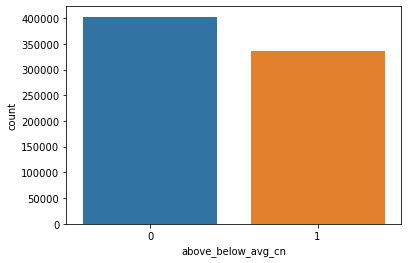

In [30]:
## Analyzing the distribution of cn 

sns.countplot(y_cn)
plt.show()

Let's start creating a baseline model using a RF classifier. Afterwards we can try
to perform some optimization and then testing other models

In [31]:
## Encoding the categorical features

X.loc[:, X.columns != 'NU_IDADE'] = X.loc[:, X.columns != 'NU_IDADE'].apply(LabelEncoder().fit_transform)

## Testing a Random Forest Classifier - a baseline model

In [27]:
# Creating the classifier

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.66 
[[63960 16563]
 [33107 34205]]


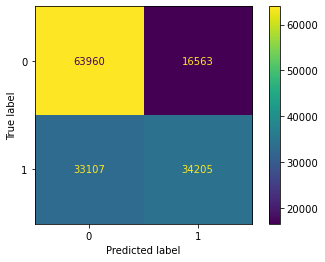

In [28]:
from sklearn.metrics import accuracy_score
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

Okay, so the model is not as good as I expected, let's see if it's possible
to improve the model's performance by dropping some components.

In [32]:
def plot_feature_importance(model):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns[:15])),
                               columns=['Value','Feature'])

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Features', fontsize = 16)
    plt.tight_layout()
    plt.show()

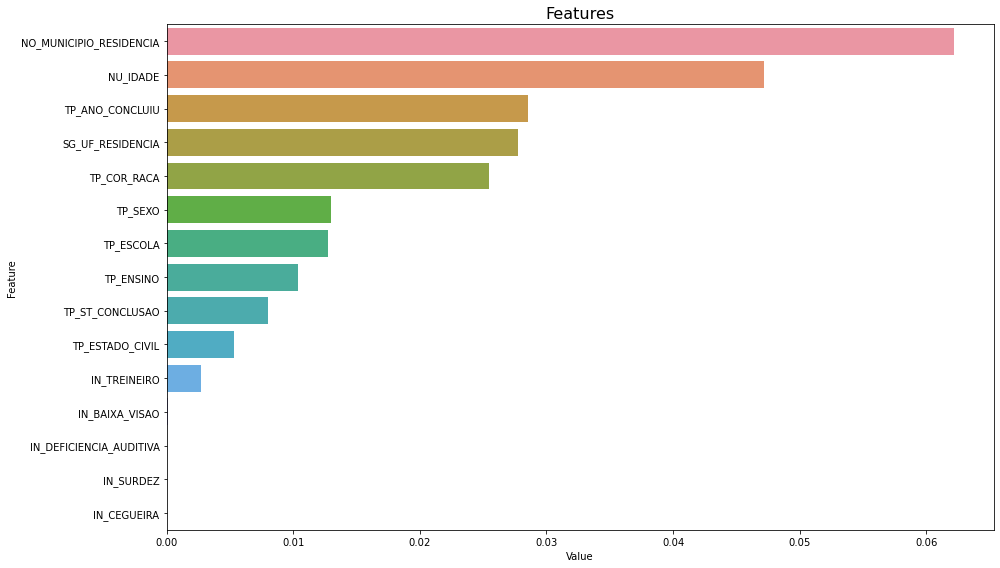

In [32]:
plot_feature_importance(clf)

## Partial discussion

So we observe that among the 15 most important features of our model those last
four ones have basically no impact in this baseline model. Let's as a first try,
then discard all the features below "IN_TREINEIRO" and see if it improves our models accuracy.

In [33]:
cols = ['NU_IDADE', 'TP_ANO_CONCLUIU', 'SG_UF_RESIDENCIA', 'TP_SEXO',
        'TP_COR_RACA', 'NO_MUNICIPIO_RESIDENCIA', 'TP_ENSINO', 'TP_ESCOLA',
        'TP_ST_CONCLUSAO', 'TP_ESTADO_CIVIL', 'IN_TREINEIRO']

X_min = X[cols].copy()

# Creating the classifier

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.6 
[[53402 27121]
 [32398 34914]]


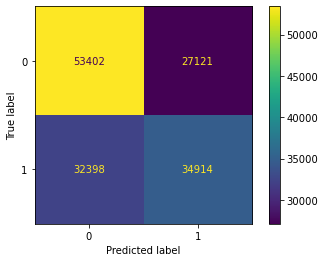

In [37]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

This decision decreases the model's performance. Let's see if we add the questions
regarding the social information

In [34]:
#list(X_min.columns)+list(X.columns[-29:-4])
cols_test = list(X_min.columns)+list(X.columns[-29:-4])

X_min = X[cols_test].copy()

In [49]:
# Creating the classifier

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.66 
[[62904 17619]
 [33187 34125]]


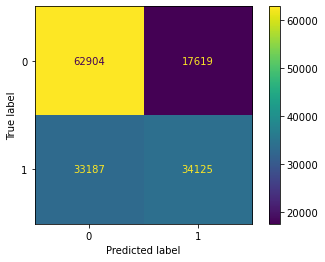

In [50]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

#Accuracy: 0.66 
#[[63960 16563]
#[33107 34205]]


## Comparison between the two confusion matrices

- We observe that after removing the features our model essentially predicted wrongly
1000 more people which scored below the mean (it predicts that they scored above the mean),
although our accuracy was kept the same. However, the changes in the confusion matrix
were not in the direction we are looking for. The main concern of our model is to predict
those which are scoring below the average. Since our new model is spoting rhougly 1000 people
less in the above of average label, we might stick with the full model and try to decrease
the number of features afterwards.


## Next steps

Sure that trying to go beyond the baseline model might lead to an accuracy improvement,
however we are simply using a RF classifier for the prediction, we aim to use later on
XGBoost, LightGBM and CatBoost, whereas the first seems to have some problems with large
amount of features the other two seems to perform better with large amount of categorical
features.
- There are a huge amount of the features related to social information that might not be
properly handled by the *LabelEncoder*, which despite not having a value per se, they have
important implications on the "social ladder" for example, generally parents with higher
salaries can enroll their children in better schools and it, consequently, might affect
the grade. Let's then go through all the questions and handle them properly.

In [35]:
cols = ['above_below_avg_cn', 'above_below_avg_ch', 'above_below_avg_lc', 'above_below_avg_mt', 'above_below_avg_red']

X = df2018_clf.drop(columns = cols).copy()


Q001 and Q002 corresponds to the parents education level, father and mother, respectively.
Despite of not being a direct correspondence, those which achieve a higher level of education
**tend** to have a better chance to haver higher salaries and all that we have already discussed.
Let's then set a numerical order to them

In [36]:
Q1_Q2 = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : -999}

#A CORRESPONDS TO NEVER STUDIED AND H CORRESPONDS TO THOSE WHICH DOESN'T HAVE THE INFORMATION

## Making the transformation
X['Q001'] = X['Q001'].apply(lambda row : Q1_Q2[row])
X['Q002'] = X['Q002'].apply(lambda row : Q1_Q2[row])


Q003 and Q004 correspond to the job of father and mother, respectively.
Again, despite of having a direct connection, these classes also correspond
to some "order" in the "social ladder". For example, the drivers are in group
C and the owners of small stores/entreprenour with less than 10 employees are
in group D. As the former, if you are a driver of a celebrity or of a politician,
you might have a very high salary, even being better paid than some medics or high-rank
officers, however, that is not generally the case. Also, to what concerns the group
D, you were an owner of a loto store 10-15 years ago you would earn per month
*way more* than the vast majority of medics, engineers and all the carreers in group E.

Since it seems like a "rule" let's stick with our plan of analyzing it with certain
order.

In [37]:
Q3_Q4 = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : -999}

# WHERE F CORRESPONDS TO THOSE WHICH DO NOT KNOW

## Making the transformation
X['Q003'] = X['Q003'].apply(lambda row : Q3_Q4[row])
X['Q004'] = X['Q004'].apply(lambda row : Q3_Q4[row])

We are basically transforming the Q001-Q004 to ordering-categorical data
Q005 is a non-categorical data

Q006 is about family income, Q007 is about if you have a housekeeper working
at your place and how many days. Again, let's set some ordering to them

In [38]:
Q6_Q7 = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'H' : 7,
         'I' : 8, 'J' : 9, 'K' : 10, 'L' : 11, 'M' : 12, 'N' : 13, 'O' : 14, 'P' : 15, 'Q' : 16}

# Q006 A CORRESPONDS TO NO INCOME, Q007 CORRESPONDS TO NO HOUSEKEEPER.

## Making the transformation
X['Q006'] = X['Q006'].apply(lambda row : Q6_Q7[row])
X['Q007'] = X['Q007'].apply(lambda row : Q6_Q7[row])

From Q008 to Q0017 all the questions are regarding to number of rooms,
number of bathrooms, etc... in the house. So it also has an ordering in it,
so let's stick to the plan and also convert them

In [39]:
X['Q008'] = X['Q008'].apply(lambda row : Q6_Q7[row])
X['Q009'] = X['Q009'].apply(lambda row : Q6_Q7[row])
X['Q010'] = X['Q010'].apply(lambda row : Q6_Q7[row])
X['Q011'] = X['Q011'].apply(lambda row : Q6_Q7[row])
X['Q012'] = X['Q012'].apply(lambda row : Q6_Q7[row])
X['Q013'] = X['Q013'].apply(lambda row : Q6_Q7[row])
X['Q014'] = X['Q014'].apply(lambda row : Q6_Q7[row])
X['Q015'] = X['Q015'].apply(lambda row : Q6_Q7[row])
X['Q016'] = X['Q016'].apply(lambda row : Q6_Q7[row])
X['Q017'] = X['Q017'].apply(lambda row : Q6_Q7[row])

From Q018 to Q015 it is basically yes-no question about
having TV or not, having internet access or not, so we can
also do the same.

In [40]:
X['Q018'] = X['Q018'].apply(lambda row : Q6_Q7[row])
X['Q019'] = X['Q019'].apply(lambda row : Q6_Q7[row])
X['Q020'] = X['Q020'].apply(lambda row : Q6_Q7[row])
X['Q021'] = X['Q021'].apply(lambda row : Q6_Q7[row])
X['Q022'] = X['Q022'].apply(lambda row : Q6_Q7[row])
X['Q023'] = X['Q023'].apply(lambda row : Q6_Q7[row])
X['Q024'] = X['Q024'].apply(lambda row : Q6_Q7[row])
X['Q025'] = X['Q025'].apply(lambda row : Q6_Q7[row])

Q026 and Q027 could have some ordering if we have more
information about them, so let's keep them as they are.

## Partial conclusion

To sum up, among all the 27 questions the only ones which didn't
have an order involved are Q026 and Q027. Consequently,
in the next LabelEncoder() all other questions will skept but Q026 and Q027.

Taking a closer look on the data, we also see that the column "TP_ANO_CONCLUIU"
also brings some ordering in it. It tells the year the the applicant finished
his highschool. 0 corresponds to "didn't answer", 1 corresponds "finish in the
year of the exam", 2 "previous year", so it has some ordering indeed.
However, 0 didn't have any directly connect to the other, therefore, lets set
it to -999

In [41]:
## correcting the TP_ANO_CONCLUIU column

X['TP_ANO_CONCLUIU'] = X['TP_ANO_CONCLUIU'].apply(lambda row : -999 if row == 0 else row)

#print(X['TP_ANO_CONCLUIU'].unique())

cols_questions = list(X.columns[-29: -4])

cols = cols_questions + ['NU_IDADE','TP_ANO_CONCLUIU']

print(cols)

['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'NU_IDADE', 'TP_ANO_CONCLUIU']


In [42]:
#X.loc[:, X.columns != cols] = X.loc[:, X.columns != cols].apply(LabelEncoder().fit_transform)

#X.head()

X[X.columns.difference(cols)] = X[X.columns.difference(cols)].apply(LabelEncoder().fit_transform)

In [62]:
# Creating the classifier with the new featuretable

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.66 
[[63755 16768]
 [32892 34420]]


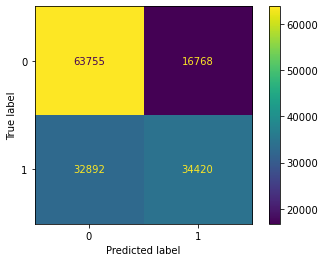

In [63]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()
#[[63960 16563]
#[33107 34205]]

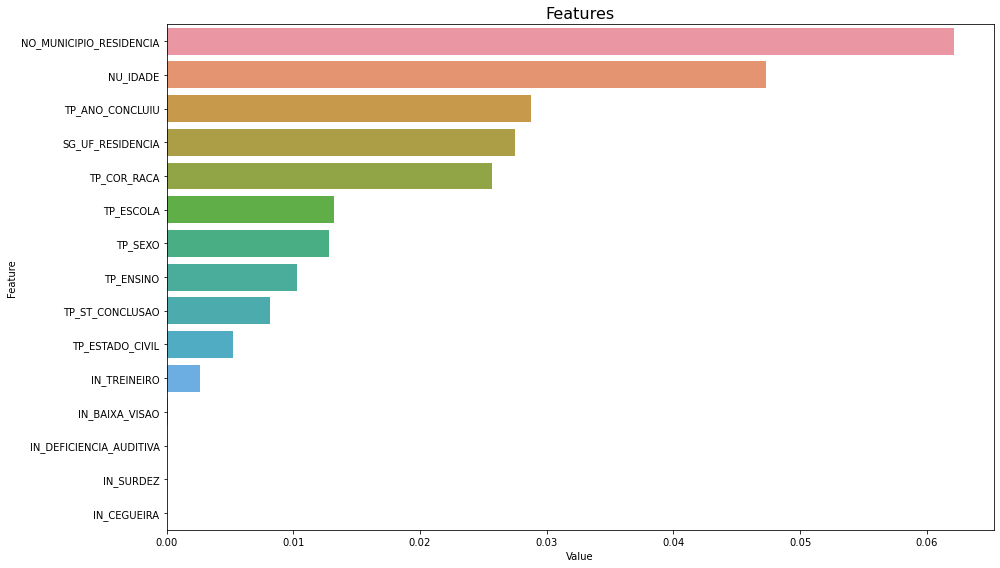

In [64]:
plot_feature_importance(clf)

In [65]:
cols_test = list(X_min.columns)+list(X.columns[-29:-4])

X_min = X[cols_test].copy()

In [68]:
# Creating the classifier with the new featuretable

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8, random_state = 0)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy: 0.65 
[[62490 18033]
 [33061 34251]]


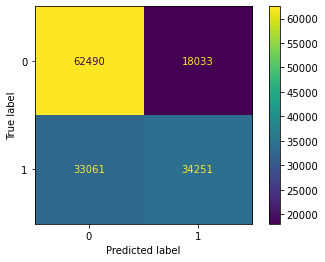

In [69]:
print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()

#Accuracy: 0.66 
#[[63960 16563]
#[33107 34205]]

## Saving the data for future purpose

Before going into XGBoost classifier, let's save the data already treated

In [46]:
X.to_csv('X.csv')
X_min.to_csv('X_min.csv')
y_cn.to_csv('above_below_avg_cn.csv')
y_ch.to_csv('above_below_avg_ch.csv')
y_lc.to_csv('above_below_avg_lc.csv')
y_mt.to_csv('above_below_avg_mt.csv')
y_red.to_csv('above_below_avg_red.csv')

## XGboost classifier

Let's start analyzing other classifiers and see how they perform
on our dataset prior to any hyperparameter tunning

In [3]:
X_min = pd.read_csv('X_min.csv')
y_cn = pd.read_csv('X_min.csv')

In [5]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X_min, y_cn, train_size = 0.8,
                                                    random_state = 0)

clf = XGBClassifier(objective = 'binary:logistic', seed = 0)

clf.fit(X_train, y_train, verbose = False,
        eval_metric = 'logloss',
        eval_set= [(X_test, y_test)],
        early_stopping_rounds = 10)

y_pred = clf.predict(X_test)

print('Accuracy: {} '.format(round(accuracy_score(y_test, y_pred), 2))) 
print (confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_true = y_test, estimator = clf, X = X_test)

plt.show()
#clf.fit(X_train, y_train, verbose = False,
#        eval_metric = 'logloss',
#        eval_set= [(X_test, y_test)],
#        early_stopping_rounds = 10)


ValueError: y should be a 1d array, got an array of shape (591340, 37) instead.

Okay so it make a worser job.

Let's investigate how Lightgbm and  catboost perform.
They are better suited for this problems with a bunch of
features and might perform better.

In [44]:
clf = CatBoostClassifier(iterations = 1000, depth = 7, learning_rate = 0.1,
                         loss_function = 'Logloss')

clf.fit(X_train, y_train,
       eval_set = (X_test, y_test))

0:	learn: 0.6880418	test: 0.6880710	best: 0.6880710 (0)	total: 73ms	remaining: 1m 12s
1:	learn: 0.6833148	test: 0.6833722	best: 0.6833722 (1)	total: 133ms	remaining: 1m 6s
2:	learn: 0.6794392	test: 0.6796540	best: 0.6796540 (2)	total: 193ms	remaining: 1m 4s
3:	learn: 0.6762453	test: 0.6766840	best: 0.6766840 (3)	total: 256ms	remaining: 1m 3s
4:	learn: 0.6738104	test: 0.6743327	best: 0.6743327 (4)	total: 318ms	remaining: 1m 3s
5:	learn: 0.6715953	test: 0.6720894	best: 0.6720894 (5)	total: 394ms	remaining: 1m 5s
6:	learn: 0.6699447	test: 0.6706087	best: 0.6706087 (6)	total: 462ms	remaining: 1m 5s
7:	learn: 0.6682739	test: 0.6691382	best: 0.6691382 (7)	total: 536ms	remaining: 1m 6s
8:	learn: 0.6670130	test: 0.6679388	best: 0.6679388 (8)	total: 612ms	remaining: 1m 7s
9:	learn: 0.6663677	test: 0.6672737	best: 0.6672737 (9)	total: 690ms	remaining: 1m 8s
10:	learn: 0.6654239	test: 0.6663013	best: 0.6663013 (10)	total: 760ms	remaining: 1m 8s
11:	learn: 0.6640857	test: 0.6650151	best: 0.6650151

95:	learn: 0.6455972	test: 0.6512387	best: 0.6512387 (95)	total: 6.72s	remaining: 1m 3s
96:	learn: 0.6454609	test: 0.6512410	best: 0.6512387 (95)	total: 6.79s	remaining: 1m 3s
97:	learn: 0.6453208	test: 0.6512153	best: 0.6512153 (97)	total: 6.9s	remaining: 1m 3s
98:	learn: 0.6451946	test: 0.6512030	best: 0.6512030 (98)	total: 7.01s	remaining: 1m 3s
99:	learn: 0.6450770	test: 0.6512173	best: 0.6512030 (98)	total: 7.09s	remaining: 1m 3s
100:	learn: 0.6449266	test: 0.6511718	best: 0.6511718 (100)	total: 7.24s	remaining: 1m 4s
101:	learn: 0.6447852	test: 0.6510728	best: 0.6510728 (101)	total: 7.35s	remaining: 1m 4s
102:	learn: 0.6446968	test: 0.6510351	best: 0.6510351 (102)	total: 7.46s	remaining: 1m 4s
103:	learn: 0.6446416	test: 0.6510218	best: 0.6510218 (103)	total: 7.57s	remaining: 1m 5s
104:	learn: 0.6445955	test: 0.6509991	best: 0.6509991 (104)	total: 7.65s	remaining: 1m 5s
105:	learn: 0.6444974	test: 0.6509940	best: 0.6509940 (105)	total: 7.71s	remaining: 1m 5s
106:	learn: 0.6444764

187:	learn: 0.6371664	test: 0.6496393	best: 0.6495641 (181)	total: 15s	remaining: 1m 4s
188:	learn: 0.6371000	test: 0.6496325	best: 0.6495641 (181)	total: 15s	remaining: 1m 4s
189:	learn: 0.6370818	test: 0.6496040	best: 0.6495641 (181)	total: 15.1s	remaining: 1m 4s
190:	learn: 0.6370259	test: 0.6495967	best: 0.6495641 (181)	total: 15.2s	remaining: 1m 4s
191:	learn: 0.6369359	test: 0.6495551	best: 0.6495551 (191)	total: 15.2s	remaining: 1m 4s
192:	learn: 0.6368582	test: 0.6495597	best: 0.6495551 (191)	total: 15.3s	remaining: 1m 4s
193:	learn: 0.6367697	test: 0.6495446	best: 0.6495446 (193)	total: 15.4s	remaining: 1m 3s
194:	learn: 0.6367242	test: 0.6495379	best: 0.6495379 (194)	total: 15.5s	remaining: 1m 3s
195:	learn: 0.6366554	test: 0.6495313	best: 0.6495313 (195)	total: 15.5s	remaining: 1m 3s
196:	learn: 0.6366078	test: 0.6495246	best: 0.6495246 (196)	total: 15.6s	remaining: 1m 3s
197:	learn: 0.6365557	test: 0.6494889	best: 0.6494889 (197)	total: 15.7s	remaining: 1m 3s
198:	learn: 0.

282:	learn: 0.6310733	test: 0.6499334	best: 0.6494374 (235)	total: 21.4s	remaining: 54.3s
283:	learn: 0.6310151	test: 0.6499223	best: 0.6494374 (235)	total: 21.5s	remaining: 54.2s
284:	learn: 0.6309507	test: 0.6499356	best: 0.6494374 (235)	total: 21.5s	remaining: 54.1s
285:	learn: 0.6308986	test: 0.6499051	best: 0.6494374 (235)	total: 21.6s	remaining: 54s
286:	learn: 0.6308499	test: 0.6498871	best: 0.6494374 (235)	total: 21.7s	remaining: 53.9s
287:	learn: 0.6308010	test: 0.6498707	best: 0.6494374 (235)	total: 21.7s	remaining: 53.8s
288:	learn: 0.6307817	test: 0.6498659	best: 0.6494374 (235)	total: 21.8s	remaining: 53.7s
289:	learn: 0.6307678	test: 0.6498666	best: 0.6494374 (235)	total: 21.9s	remaining: 53.6s
290:	learn: 0.6306814	test: 0.6498898	best: 0.6494374 (235)	total: 22s	remaining: 53.5s
291:	learn: 0.6306213	test: 0.6499058	best: 0.6494374 (235)	total: 22s	remaining: 53.4s
292:	learn: 0.6305508	test: 0.6498936	best: 0.6494374 (235)	total: 22.1s	remaining: 53.3s
293:	learn: 0.63

374:	learn: 0.6264571	test: 0.6504207	best: 0.6494374 (235)	total: 27.5s	remaining: 45.9s
375:	learn: 0.6263494	test: 0.6504632	best: 0.6494374 (235)	total: 27.6s	remaining: 45.9s
376:	learn: 0.6263132	test: 0.6504624	best: 0.6494374 (235)	total: 27.7s	remaining: 45.8s
377:	learn: 0.6262888	test: 0.6504768	best: 0.6494374 (235)	total: 27.8s	remaining: 45.7s
378:	learn: 0.6262486	test: 0.6504911	best: 0.6494374 (235)	total: 27.9s	remaining: 45.6s
379:	learn: 0.6262113	test: 0.6504880	best: 0.6494374 (235)	total: 27.9s	remaining: 45.5s
380:	learn: 0.6261534	test: 0.6505256	best: 0.6494374 (235)	total: 28s	remaining: 45.5s
381:	learn: 0.6260995	test: 0.6505644	best: 0.6494374 (235)	total: 28s	remaining: 45.4s
382:	learn: 0.6260369	test: 0.6505926	best: 0.6494374 (235)	total: 28.1s	remaining: 45.3s
383:	learn: 0.6259977	test: 0.6505846	best: 0.6494374 (235)	total: 28.2s	remaining: 45.2s
384:	learn: 0.6259520	test: 0.6505826	best: 0.6494374 (235)	total: 28.2s	remaining: 45.1s
385:	learn: 0.

469:	learn: 0.6221114	test: 0.6514588	best: 0.6494374 (235)	total: 34.1s	remaining: 38.4s
470:	learn: 0.6220613	test: 0.6514341	best: 0.6494374 (235)	total: 34.1s	remaining: 38.3s
471:	learn: 0.6220423	test: 0.6514577	best: 0.6494374 (235)	total: 34.2s	remaining: 38.2s
472:	learn: 0.6219718	test: 0.6514456	best: 0.6494374 (235)	total: 34.2s	remaining: 38.1s
473:	learn: 0.6219428	test: 0.6514486	best: 0.6494374 (235)	total: 34.3s	remaining: 38.1s
474:	learn: 0.6218935	test: 0.6514838	best: 0.6494374 (235)	total: 34.4s	remaining: 38s
475:	learn: 0.6218610	test: 0.6514890	best: 0.6494374 (235)	total: 34.4s	remaining: 37.9s
476:	learn: 0.6218352	test: 0.6514871	best: 0.6494374 (235)	total: 34.5s	remaining: 37.8s
477:	learn: 0.6218233	test: 0.6514783	best: 0.6494374 (235)	total: 34.5s	remaining: 37.7s
478:	learn: 0.6217924	test: 0.6514532	best: 0.6494374 (235)	total: 34.6s	remaining: 37.6s
479:	learn: 0.6217776	test: 0.6514555	best: 0.6494374 (235)	total: 34.7s	remaining: 37.5s
480:	learn: 

563:	learn: 0.6185260	test: 0.6520109	best: 0.6494374 (235)	total: 42.4s	remaining: 32.7s
564:	learn: 0.6185010	test: 0.6520108	best: 0.6494374 (235)	total: 42.5s	remaining: 32.7s
565:	learn: 0.6184688	test: 0.6520257	best: 0.6494374 (235)	total: 42.6s	remaining: 32.7s
566:	learn: 0.6184206	test: 0.6520344	best: 0.6494374 (235)	total: 42.7s	remaining: 32.6s
567:	learn: 0.6183883	test: 0.6520370	best: 0.6494374 (235)	total: 42.7s	remaining: 32.5s
568:	learn: 0.6183635	test: 0.6520627	best: 0.6494374 (235)	total: 42.8s	remaining: 32.4s
569:	learn: 0.6183352	test: 0.6520922	best: 0.6494374 (235)	total: 42.9s	remaining: 32.3s
570:	learn: 0.6183238	test: 0.6520893	best: 0.6494374 (235)	total: 42.9s	remaining: 32.3s
571:	learn: 0.6182748	test: 0.6521290	best: 0.6494374 (235)	total: 43s	remaining: 32.2s
572:	learn: 0.6182505	test: 0.6521373	best: 0.6494374 (235)	total: 43.1s	remaining: 32.1s
573:	learn: 0.6181864	test: 0.6521437	best: 0.6494374 (235)	total: 43.2s	remaining: 32s
574:	learn: 0.

656:	learn: 0.6153647	test: 0.6530601	best: 0.6494374 (235)	total: 51s	remaining: 26.6s
657:	learn: 0.6153271	test: 0.6530981	best: 0.6494374 (235)	total: 51s	remaining: 26.5s
658:	learn: 0.6153105	test: 0.6531204	best: 0.6494374 (235)	total: 51.1s	remaining: 26.4s
659:	learn: 0.6152543	test: 0.6531180	best: 0.6494374 (235)	total: 51.2s	remaining: 26.4s
660:	learn: 0.6152235	test: 0.6531117	best: 0.6494374 (235)	total: 51.3s	remaining: 26.3s
661:	learn: 0.6151820	test: 0.6531450	best: 0.6494374 (235)	total: 51.4s	remaining: 26.3s
662:	learn: 0.6151627	test: 0.6531373	best: 0.6494374 (235)	total: 51.5s	remaining: 26.2s
663:	learn: 0.6151367	test: 0.6531716	best: 0.6494374 (235)	total: 51.6s	remaining: 26.1s
664:	learn: 0.6151122	test: 0.6531674	best: 0.6494374 (235)	total: 51.6s	remaining: 26s
665:	learn: 0.6150691	test: 0.6531941	best: 0.6494374 (235)	total: 51.7s	remaining: 25.9s
666:	learn: 0.6150457	test: 0.6531754	best: 0.6494374 (235)	total: 51.8s	remaining: 25.9s
667:	learn: 0.61

749:	learn: 0.6124654	test: 0.6539398	best: 0.6494374 (235)	total: 58.5s	remaining: 19.5s
750:	learn: 0.6124362	test: 0.6539343	best: 0.6494374 (235)	total: 58.6s	remaining: 19.4s
751:	learn: 0.6124113	test: 0.6539083	best: 0.6494374 (235)	total: 58.7s	remaining: 19.4s
752:	learn: 0.6123881	test: 0.6539194	best: 0.6494374 (235)	total: 58.8s	remaining: 19.3s
753:	learn: 0.6123452	test: 0.6539303	best: 0.6494374 (235)	total: 58.9s	remaining: 19.2s
754:	learn: 0.6123215	test: 0.6539488	best: 0.6494374 (235)	total: 58.9s	remaining: 19.1s
755:	learn: 0.6123056	test: 0.6539603	best: 0.6494374 (235)	total: 59s	remaining: 19s
756:	learn: 0.6122828	test: 0.6539692	best: 0.6494374 (235)	total: 59.1s	remaining: 19s
757:	learn: 0.6122538	test: 0.6539872	best: 0.6494374 (235)	total: 59.1s	remaining: 18.9s
758:	learn: 0.6122399	test: 0.6540096	best: 0.6494374 (235)	total: 59.2s	remaining: 18.8s
759:	learn: 0.6122007	test: 0.6540268	best: 0.6494374 (235)	total: 59.3s	remaining: 18.7s
760:	learn: 0.61

841:	learn: 0.6098172	test: 0.6549536	best: 0.6494374 (235)	total: 1m 6s	remaining: 12.5s
842:	learn: 0.6097664	test: 0.6549640	best: 0.6494374 (235)	total: 1m 6s	remaining: 12.4s
843:	learn: 0.6097539	test: 0.6549570	best: 0.6494374 (235)	total: 1m 6s	remaining: 12.3s
844:	learn: 0.6097207	test: 0.6549675	best: 0.6494374 (235)	total: 1m 6s	remaining: 12.3s
845:	learn: 0.6096439	test: 0.6549810	best: 0.6494374 (235)	total: 1m 7s	remaining: 12.2s
846:	learn: 0.6095911	test: 0.6549824	best: 0.6494374 (235)	total: 1m 7s	remaining: 12.1s
847:	learn: 0.6095862	test: 0.6549967	best: 0.6494374 (235)	total: 1m 7s	remaining: 12s
848:	learn: 0.6095398	test: 0.6550208	best: 0.6494374 (235)	total: 1m 7s	remaining: 12s
849:	learn: 0.6095124	test: 0.6550240	best: 0.6494374 (235)	total: 1m 7s	remaining: 11.9s
850:	learn: 0.6095063	test: 0.6550396	best: 0.6494374 (235)	total: 1m 7s	remaining: 11.8s
851:	learn: 0.6094779	test: 0.6550310	best: 0.6494374 (235)	total: 1m 7s	remaining: 11.7s
852:	learn: 0.

932:	learn: 0.6070151	test: 0.6557995	best: 0.6494374 (235)	total: 1m 13s	remaining: 5.3s
933:	learn: 0.6070074	test: 0.6558117	best: 0.6494374 (235)	total: 1m 13s	remaining: 5.22s
934:	learn: 0.6069978	test: 0.6558167	best: 0.6494374 (235)	total: 1m 14s	remaining: 5.14s
935:	learn: 0.6069673	test: 0.6558331	best: 0.6494374 (235)	total: 1m 14s	remaining: 5.07s
936:	learn: 0.6069424	test: 0.6558334	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.99s
937:	learn: 0.6069206	test: 0.6558293	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.91s
938:	learn: 0.6068674	test: 0.6558483	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.83s
939:	learn: 0.6068293	test: 0.6558627	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.75s
940:	learn: 0.6067909	test: 0.6558727	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.67s
941:	learn: 0.6067864	test: 0.6558815	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.59s
942:	learn: 0.6067467	test: 0.6558640	best: 0.6494374 (235)	total: 1m 14s	remaining: 4.51s


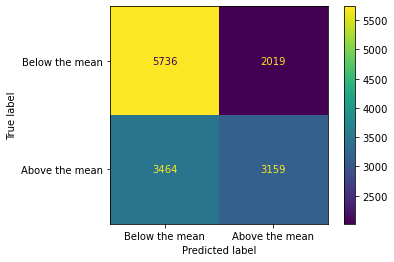

In [45]:
plot_confusion_matrix(clf, X_test, y_test, display_labels = ['Below the mean', 'Above the mean'])
plt.show()

## Next steps

Okay, so across the models we didn't see any huge change. We then might
need some feature engineering to better express the data information.
For example, some data in the questions express a certain order, could
be relevant to try to express them with a certain order already.

In [186]:
X.loc[:, X.columns != 'NU_IDADE'] = X.loc[:, X.columns != 'NU_IDADE'].apply(LabelEncoder().fit_transform)
X.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,...,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,capital_or_not,single_or_not
1,9,23.00,0,0,3,0,5,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,14,23.00,0,0,1,0,5,0,0,0,...,0,0,1,0,1,1,0,0,1,1
7,16,39.00,1,1,3,0,12,0,0,0,...,1,0,1,0,1,1,0,0,0,0
8,5,19.00,1,0,3,1,0,1,0,0,...,1,0,1,0,0,0,1,0,1,1
9,12,25.00,0,0,3,0,9,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [43]:
def model_subject(y_cn):

    params = {'is_unbalance' : True,
              'boosting_type' : 'gbdt',
              'objective' : 'regression',
              'metric' : 'l2',#'l1',
              'num_iterations' : 2000,
              'verbosity' : -1,
              'num_leaves': 32,
              'learning_rate': 0.05
              #'lambda_l2': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              #'lambda_l1': [1e-4, 1e-3, 1e-2, 1e-1, 1]
             }

    X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0)
    
    #lgb_train = lgb.Dataset(X_train, y_train)
    #lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

    kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
    

    rmse_scores = []
    i = 1

    for train_index, test_index in kf.split(X_train, y_train):
        print('Training the model using the folder number {}'.format(i))
        
        X_kfold_train, X_kfold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
        
        model_lgbm = lgb.LGBMRegressor(**params)
        model_lgbm.fit(X_kfold_train, y_kfold_train,
                       eval_set = [(X_kfold_train, y_kfold_train), (X_kfold_test, y_kfold_test)],
                      early_stopping_rounds = int(params['num_iterations']), verbose = False)
    
        y_kfold_pred = model_lgbm.predict(X_kfold_test)
        rmse = np.sqrt(mean_squared_error(y_kfold_test, y_kfold_pred))
        rmse_scores.append(rmse)
        
        rmse_std_comparison = round(rmse/y_kfold_test.std(), 2)
        
        print('RMSE over the validation set: {:.3f}'.format(round(rmse, 2)))
        print('RMSE over the validation set compared to the std: {}'.format(rmse_std_comparison))
        print(' ')
    
        i += 1
    
    y_pred = model_lgbm.predict(X_test)
    error = pd.Series(y_pred) - y_test
    
    rmse_std_comp = round(np.sqrt(mean_squared_error(y_pred, y_test))/y_test.std(), 2)
    
    print('RMSE compared to the std: {}'.format(rmse_std_comp))
    
    
    return model_lgbm, y_pred, error, X_test, y_test

In [18]:
natural_science_info = model_subject(y_cn)

Training the model using the folder number 1
RMSE over the validation set: 63.730
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 64.590
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 3
RMSE over the validation set: 64.290
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 4
RMSE over the validation set: 64.670
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 64.180
RMSE over the validation set compared to the std: 0.86
 
RMSE compared to the std: 0.87


In [45]:
def plot_feature_importance(model_lgbm):
    feature_imp = pd.DataFrame(sorted(zip(model_lgbm.feature_importances_,X.columns[:20])),
                               columns=['Value','Feature'])

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

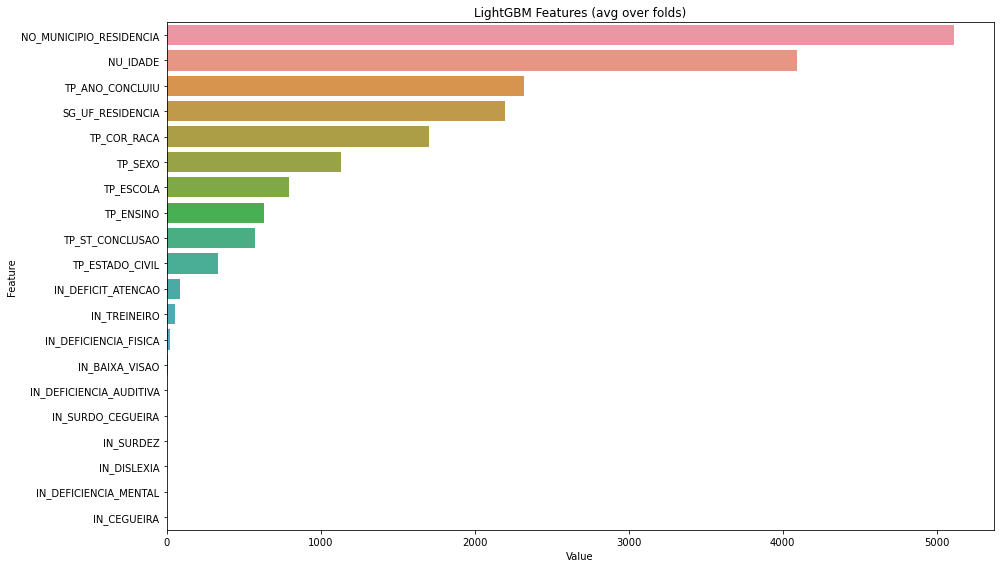

In [20]:
plot_feature_importance(natural_science_info[0])

In [46]:
#Error analysis
def error_analysis(error, y_cn):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    sns.histplot(error, ax=ax1)
    sns.histplot(y_cn, ax=ax2, bins = 50)
    ax1.set_xlabel('Error for grades the grades', fontsize = 14)
    ax1.set_xlim([-300, 300])
    
    ax2.set_xlabel('Grade distribution', fontsize = 14)
    plt.show()

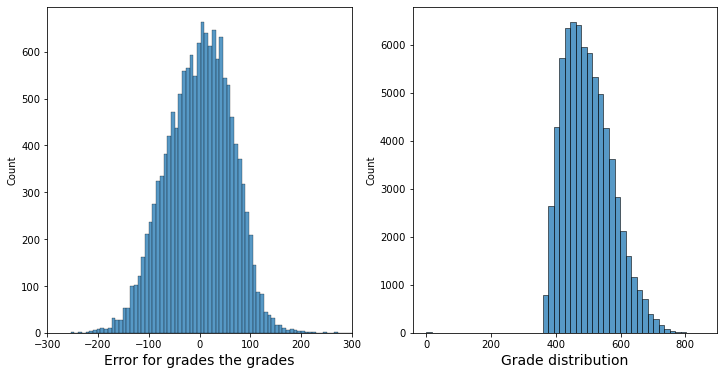

In [35]:
error = natural_science_info[2]
error_analysis(error, y_cn)

Model analysis for natural sciences...
 
Training the model using the folder number 1
RMSE over the validation set: 63.730
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 64.590
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 3
RMSE over the validation set: 64.290
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 4
RMSE over the validation set: 64.670
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 64.180
RMSE over the validation set compared to the std: 0.86
 
RMSE compared to the std: 0.87
Preparing feature importance...
 


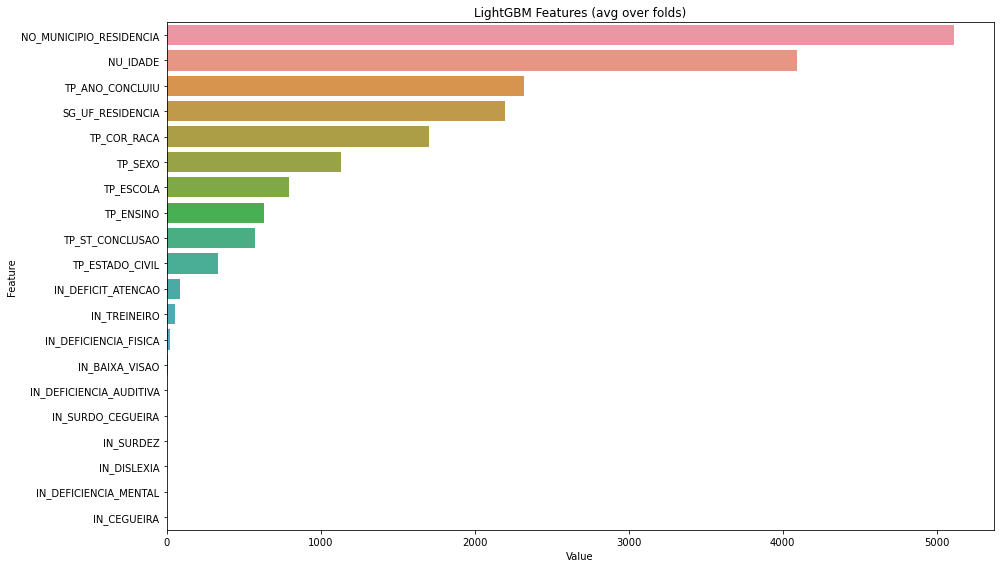

Preparing error analysis...
 


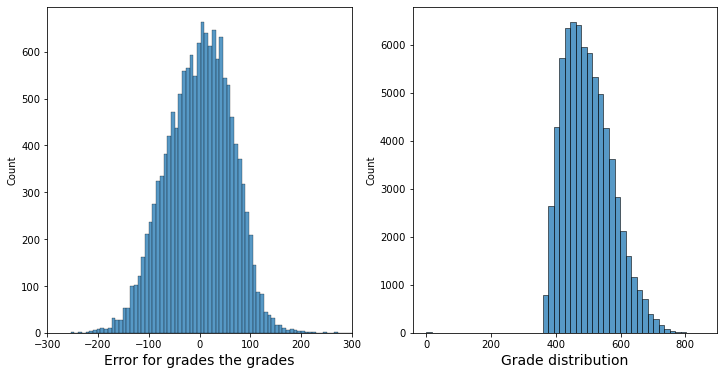

In [36]:
print ('Model analysis for natural sciences...')
print (' ')

natural_science_info = model_subject(y_cn)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(natural_science_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(natural_science_info[2], y_cn)

Model analysis for human sciences...
 
Training the model using the folder number 1
RMSE over the validation set: 68.160
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 2
RMSE over the validation set: 69.260
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 3
RMSE over the validation set: 67.550
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 4
RMSE over the validation set: 68.840
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 5
RMSE over the validation set: 69.710
RMSE over the validation set compared to the std: 0.89
 
RMSE compared to the std: 0.89
 
Preparing feature importance...
 


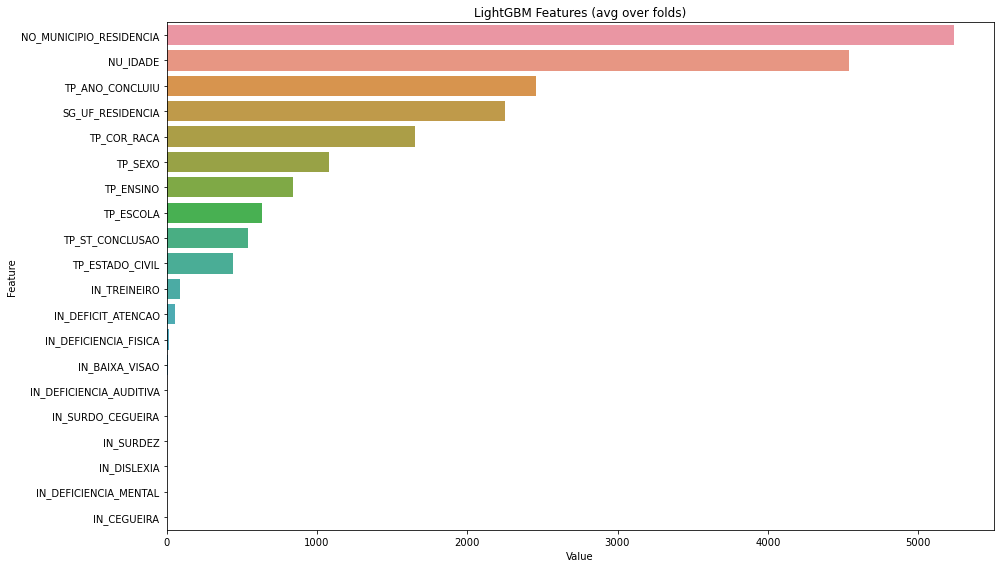

Preparing error analysis...
 


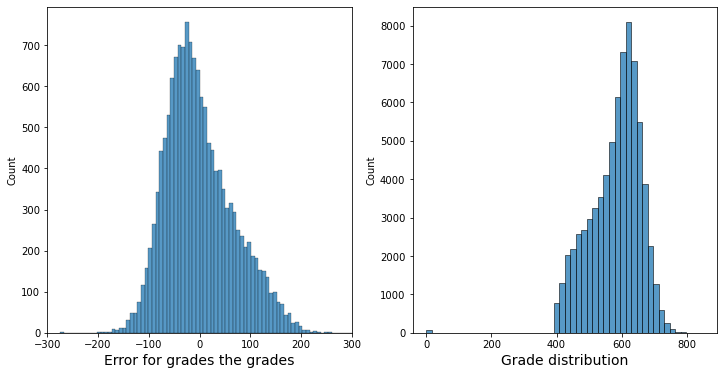

In [38]:
print ('Model analysis for human sciences...')
print (' ')

human_science_info = model_subject(y_ch)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(human_science_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(human_science_info[2], y_ch)

Model analysis for portuguese and literature...
 
Training the model using the folder number 1
RMSE over the validation set: 60.770
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 2
RMSE over the validation set: 61.450
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 3
RMSE over the validation set: 60.710
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 4
RMSE over the validation set: 60.500
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 61.380
RMSE over the validation set compared to the std: 0.85
 
RMSE compared to the std: 0.86
 
Preparing feature importance...
 


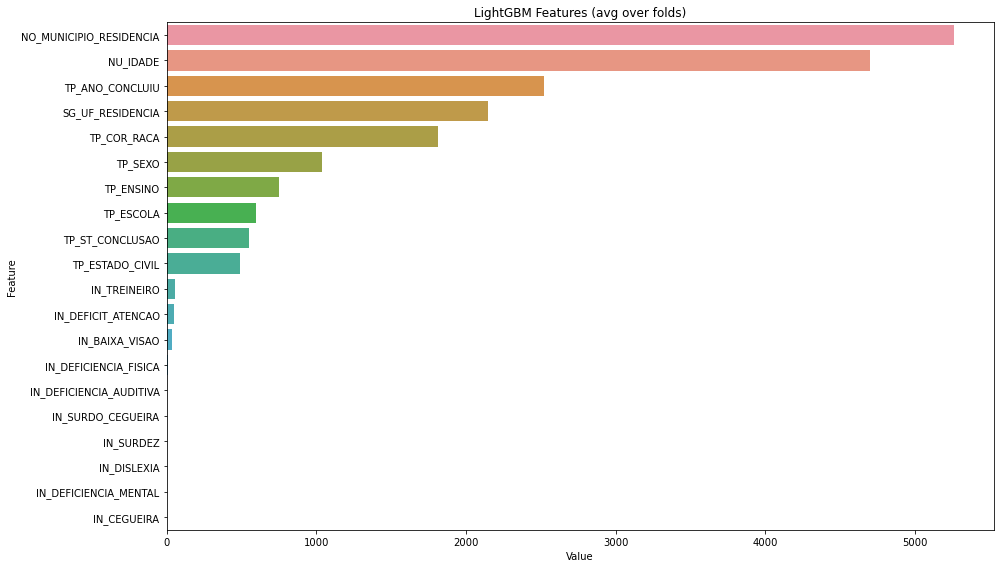

Preparing error analysis...
 


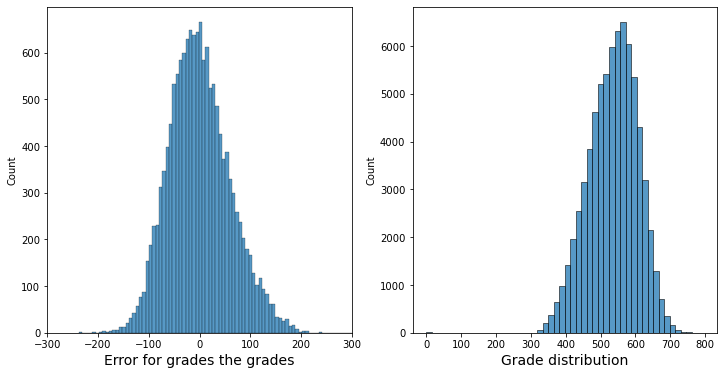

In [39]:
print ('Model analysis for portuguese and literature...')
print (' ')

port_lit_info = model_subject(y_lc)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(port_lit_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(port_lit_info[2], y_lc)

Model analysis for math...
 
Training the model using the folder number 1
RMSE over the validation set: 86.420
RMSE over the validation set compared to the std: 0.84
 
Training the model using the folder number 2
RMSE over the validation set: 86.190
RMSE over the validation set compared to the std: 0.84
 
Training the model using the folder number 3
RMSE over the validation set: 86.790
RMSE over the validation set compared to the std: 0.85
 
Training the model using the folder number 4
RMSE over the validation set: 86.640
RMSE over the validation set compared to the std: 0.84
 
Training the model using the folder number 5
RMSE over the validation set: 86.410
RMSE over the validation set compared to the std: 0.84
 
RMSE compared to the std: 0.84
 
Preparing feature importance...
 


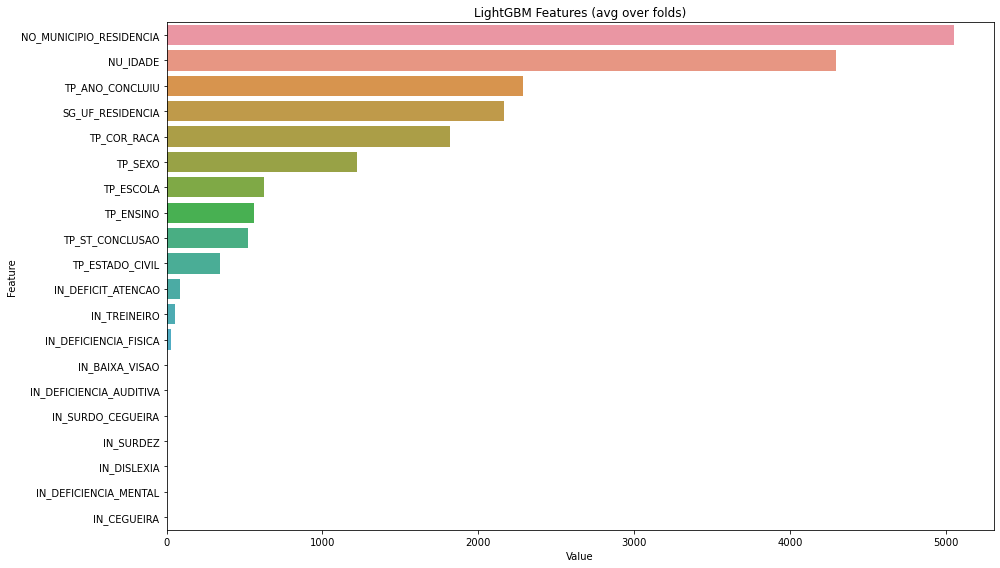

Preparing error analysis...
 


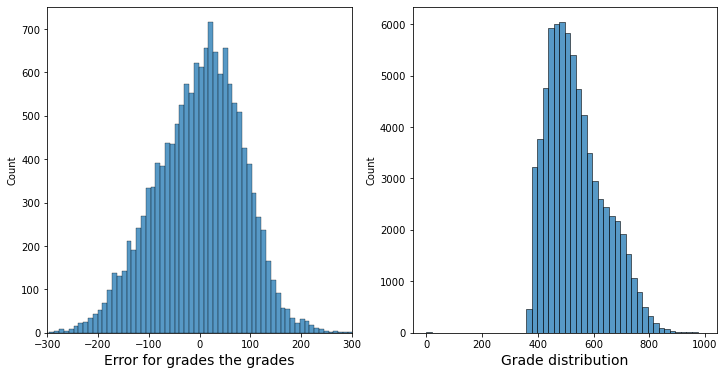

In [40]:
print ('Model analysis for math...')
print (' ')

math_info = model_subject(y_mt)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(math_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(math_info[2], y_mt)

Model analysis for the essay...
 
Training the model using the folder number 1
RMSE over the validation set: 153.860
RMSE over the validation set compared to the std: 0.88
 
Training the model using the folder number 2
RMSE over the validation set: 156.190
RMSE over the validation set compared to the std: 0.89
 
Training the model using the folder number 3
RMSE over the validation set: 155.370
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 4
RMSE over the validation set: 154.020
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 5
RMSE over the validation set: 155.200
RMSE over the validation set compared to the std: 0.88
 
RMSE compared to the std: 0.88
 
Preparing feature importance...
 


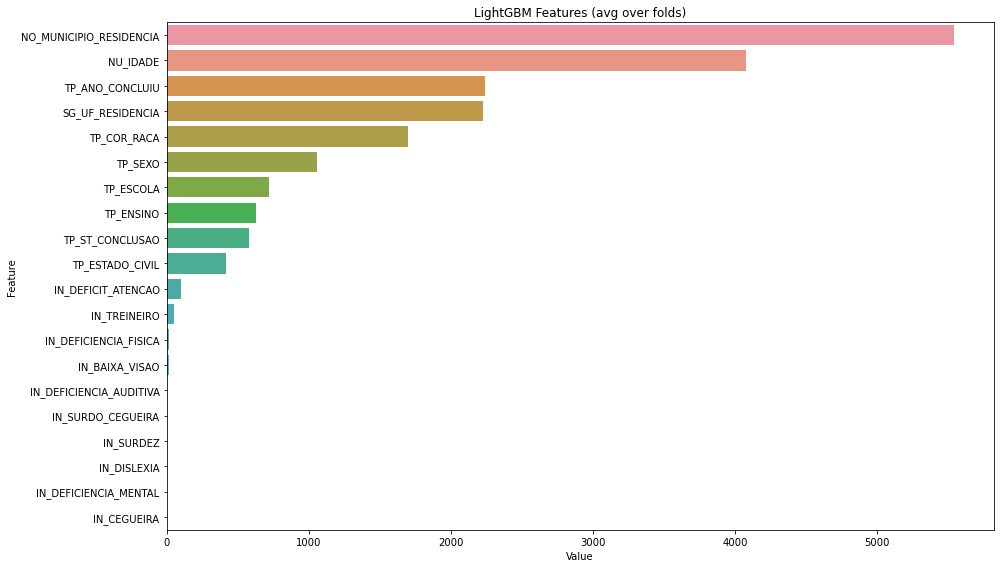

Preparing error analysis...
 


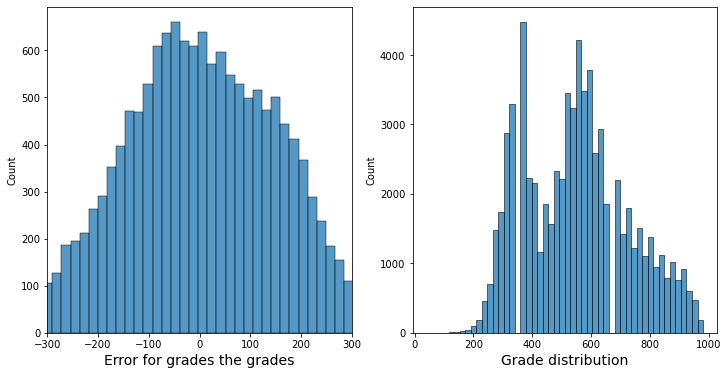

In [47]:
print ('Model analysis for the essay...')
print (' ')

essay_info = model_subject(y_redacao)

print (' ')
print ('Preparing feature importance...')
print (' ')

plot_feature_importance(essay_info[0])

print ('Preparing error analysis...')
print (' ')

error_analysis(essay_info[2], y_redacao)

## Brief discussion about the models prediction and the error analysis

Apart from the essay prediction, the rest of the predictions have their errors nicely
distributed in a Gaussian shape around zero. However, we observe that most of the grades
(except for portuguese and literature) are at least slightly skewed. That might be
compromising our model. There are a couple of points to further investigate. Since data
is unbalanced we can try to oversample part of of it try to balance it. A third option
would be to reconstruct at least the most relevant features. For example, one of the
questions which is relevant for all of the models is if the person has computer at
home or not. However, it has several options acoordingly to the number of computers
at home which might be necessary. So the first move that we are going to do is
check the relevant features and reformulate part of it.

In [ ]:
#Error analysis
def error_analysis(error, y_cn):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    sns.histplot(error, ax=ax1)
    sns.histplot(y_cn, ax=ax2, bins = 50)
    ax1.set_xlabel('Error for grades the grades', fontsize = 14)
    ax1.set_xlim([-300, 300])
    
    ax2.set_xlabel('Grade distribution', fontsize = 14)
    plt.show()

In [32]:
X.head()

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
1,São João dos Patos,MA,23.00,F,0.00,3,1,5,1,1.00,...,A,B,A,A,B,A,A,A,A,A
5,João Pessoa,PB,23.00,F,0.00,1,1,5,1,1.00,...,A,B,A,A,B,A,B,B,A,A
7,Parnaíba,PI,39.00,M,1.00,3,1,12,1,1.00,...,A,C,B,A,B,A,B,B,A,A
8,Fortaleza,CE,19.00,M,0.00,3,2,0,2,1.00,...,A,B,B,A,B,A,A,A,B,A
9,Cuiabá,MT,25.00,F,0.00,3,1,9,1,1.00,...,A,B,A,A,B,A,A,A,A,A


In [37]:
## Analyzing the range of grades distribution
## NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_LC, NU_NOTA_MT

cols = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
names = ['Natural Sciences', 'Human Sciences', 'Portuguese and Literature', 'Mathematics', 'Essay']



def grade_range_dist(col, name):
    df = df2018[[col]].copy()
    df['range'] = 0

    df.loc[(df[col] > 0) & (df[col] <= 100),'range'] = 1
    df.loc[(df[col] > 100) & (df[col] <= 200),'range'] = 2
    df.loc[(df[col] > 200) & (df[col] <= 300),'range'] = 3
    df.loc[(df[col] > 300) & (df[col] <= 400),'range'] = 4
    df.loc[(df[col] > 400) & (df[col] <= 500),'range'] = 5
    df.loc[(df[col] > 500) & (df[col] <= 600),'range'] = 6
    df.loc[(df[col] > 600) & (df[col] <= 700),'range'] = 7
    df.loc[(df[col] > 700) & (df[col] <= 800),'range'] = 8
    df.loc[(df[col] > 800) & (df[col] <= 900),'range'] = 9
    df.loc[(df[col] > 900) & (df[col] <= 1000),'range'] = 10
    
    #print(df.head())
    
    sns.displot(df['range'], binwidth = 1, alpha = 0.3, color = 'blue')
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(5, 3)
    
    ax.set_xlabel('Range for grade distribution \nin {}'.format(name), fontsize = 12)
    ax.set_ylabel('Count', fontsize = 12)
    plt.show
    #return ax

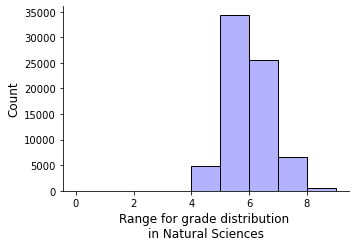

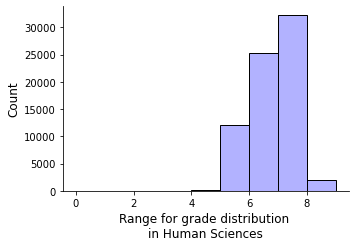

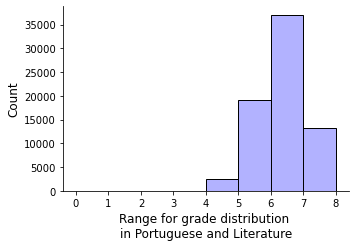

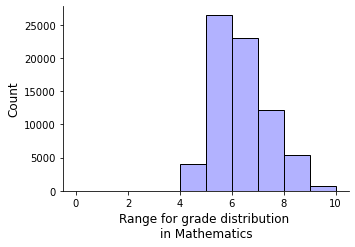

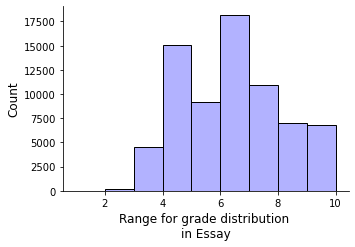

In [38]:
for i in range(len(cols)):
    grade_range_dist(cols[i], names[i])

#grade_range_dist('NU_NOTA_CN', 'Natural Sciences')

#df2018[['NU_NOTA_CN']]

## Hyperparameter tunning

In [60]:
#y_cn y_ch y_lc y_mt y_redacao Let's round it to multiple of 50 

#X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0, stratify = y_cn)    

y_cn = 50*np.around(y_cn/50)
y_ch = 50*np.around(y_ch/50)
y_mt = 50*np.around(y_mt/50)
y_lc = 50*np.around(y_lc/50)
y_redacao = 50*np.around(y_redacao/50)

X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0, stratify = y_cn)

In [ ]:
params = {'is_unbalance' : True,
          'boosting_type' : 'gbdt',
          'objective' : 'regression',
          'metric' : 'l2',#'l1',
          'num_iterations' : 2000,
          'verbosity' : -1,
          'num_leaves': 32,
          'learning_rate': 0.05
          #'lambda_l2': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
          #'lambda_l1': [1e-4, 1e-3, 1e-2, 1e-1, 1]
         }

kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
    

rmse_scores = []
i = 1

for max_depth_value in range(3, 7):
    for train_index, test_index in kf.split(X_train, y_train):
        print('Training the model using the folder number {}'.format(i))
        X_kfold_train, X_kfold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
    
        model_lgbm = lgb.LGBMRegressor(**params, max_depth = max_depth_value)
        model_lgbm.fit(X_kfold_train, y_kfold_train,
                       eval_set = [(X_kfold_train, y_kfold_train), (X_kfold_test, y_kfold_test)],
                       early_stopping_rounds = int(params['num_iterations']), verbose = False)
    
        y_kfold_pred = model_lgbm.predict(X_kfold_test)
        rmse = np.sqrt(mean_squared_error(y_kfold_test, y_kfold_pred))
        rmse_scores.append(rmse)
        
        rmse_std_comparison = round(rmse/y_kfold_test.std(), 2)
    
        print('RMSE over the validation set: {:.3f}'.format(round(rmse, 2)))
        print('RMSE over the validation set compared to the std: {}'.format(rmse_std_comparison))
        print(' ')
    
        i += 1
    
    y_pred = model_lgbm.predict(X_test)
    error = pd.Series(y_pred) - y_test
        
    rmse_std_comp = round(np.sqrt(mean_squared_error(y_pred, y_test))/y_test.std(), 2)
    
    print('RMSE compared to the std: {}'.format(rmse_std_comp))

In [64]:
def model_subject(y_cn, num_leaves = 32, learning_rate = 0.05, max_depth = 6):

    params = {'is_unbalance' : True,
              'boosting_type' : 'gbdt',
              'objective' : 'regression',
              'metric' : 'l2',#'l1',
              'num_iterations' : 2000,
              'verbosity' : -1,
              'num_leaves': num_leaves,
              'learning_rate': learning_rate,
              'max_depth': max_depth
              #'lambda_l2': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              #'lambda_l1': [1e-4, 1e-3, 1e-2, 1e-1, 1]
             }

    X_train, X_test, y_train, y_test = train_test_split(X, y_cn, test_size = 0.2, random_state = 0)

    kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
    

    rmse_scores = []
    i = 1

    for train_index, test_index in kf.split(X_train, y_train):
        print('Training the model using the folder number {}'.format(i))
        
        X_kfold_train, X_kfold_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
        
        model_lgbm = lgb.LGBMRegressor(**params)
        model_lgbm.fit(X_kfold_train, y_kfold_train,
                       eval_set = [(X_kfold_train, y_kfold_train), (X_kfold_test, y_kfold_test)],
                      early_stopping_rounds = int(params['num_iterations']), verbose = False)
    
        y_kfold_pred = model_lgbm.predict(X_kfold_test)
        rmse = np.sqrt(mean_squared_error(y_kfold_test, y_kfold_pred))
        rmse_scores.append(rmse)
        
        rmse_std_comparison = round(rmse/y_kfold_test.std(), 2)
        
        print('RMSE over the validation set: {:.3f}'.format(round(rmse, 2)))
        print('RMSE over the validation set compared to the std: {}'.format(rmse_std_comparison))
        print(' ')
    
        i += 1
    
    y_pred = model_lgbm.predict(X_test)
    error = pd.Series(y_pred) - y_test
    
    rmse_std_comp = round(np.sqrt(mean_squared_error(y_pred, y_test))/y_test.std(), 2)
    
    print('RMSE compared to the std for {} max_depth: {}'.format(max_depth, rmse_std_comp))
    
    return rmse_std_comp

In [65]:
max_depth_dict = dict()

for max_depth_value in range(3, 7):
    print (' ')
    print (' ')
    rmse = model_subject(y_cn, max_depth = max_depth_value)
    max_depth_dict[max_depth_value] = rmse
    print (' ')
    print (' ')

 
 
Training the model using the folder number 1
RMSE over the validation set: 65.320
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 65.560
RMSE over the validation set compared to the std: 0.87
 
Training the model using the folder number 3
RMSE over the validation set: 64.950
RMSE over the validation set compared to the std: 0.85
 
Training the model using the folder number 4
RMSE over the validation set: 64.750
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 5
RMSE over the validation set: 65.030
RMSE over the validation set compared to the std: 0.86
 
RMSE compared to the std for 3 max_depth: 0.86
 
 
 
 
Training the model using the folder number 1
RMSE over the validation set: 65.530
RMSE over the validation set compared to the std: 0.86
 
Training the model using the folder number 2
RMSE over the validation set: 65.870
RMSE over the validation 